# Load Libraries

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Flatten, Reshape, Embedding,ActivityRegularization, Lambda, Input,Multiply,Activation
from tensorflow.keras.models import Model
import changefinder
import seaborn as sns
from scipy.spatial import distance
import random
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPool2D, Conv1D
from tensorflow.python.keras.layers import Layer, InputSpec
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
pd.set_option('display.max_columns', 100)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [994]:
class preprocess:
    def create_dataset(self, X, y, time_steps=1):
        self.X = X
        self.y = y
        self.Xs, self.ys = [], []
        self.time_steps = time_steps
        for self.i in range(len(self.X) - self.time_steps):
            self.v = self.X.iloc[self.i:(self.i + self.time_steps)].values
            self.Xs.append(self.v)        
            self.ys.append(self.y.iloc[self.i + self.time_steps])
        return np.array(self.Xs), np.array(self.ys)
    
    def Creating_Models(self, timesteps, num_features, hidden = 10):
        self.hidden = hidden
        self.timesteps = timesteps
        self.num_features = num_features
        self.model = Sequential([
            #Encoder
            LSTM(self.hidden, input_shape=(self.timesteps, self.num_features)),
            #Dropout(0.2),
            #Decoder
            RepeatVector(self.timesteps),
            LSTM(self.hidden, return_sequences=True),
            #Dropout(0.2),
            TimeDistributed(Dense(self.num_features))                 
        ])
        return self.model
    
    def plotting_history(self, history):
        self.history = history
        plt.figure(figsize=(4, 4))
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel("Epochs")
        plt.ylabel("loss")
        plt.legend()
        plt.show()

# Create Sample Data

In [747]:
def return_random_data1(seed):
    np.random.seed(seed)
    rand_mean1 = 50
    rand_mean2 = 60
    rand_std = 2
    random_series = np.hstack([np.random.normal(loc=rand_mean1, scale=rand_std, size=13000) , 
                               np.arange(rand_mean1, rand_mean2, (rand_mean2-rand_mean1)/500 )+np.random.normal(0, rand_std, 500), 
                               np.random.normal(loc=rand_mean2, scale=rand_std, size=1500)])
    return random_series

In [786]:
def return_random_data2(seed):
    np.random.seed(seed)
    rand_mean1 = 50
    rand_mean2 = 55
    rand_mean3 = 1.5
    freq1 = 1000
    freq2 = 2000
    freq3 = 1500

    
    random_series = np.hstack([np.sin(np.arange(13000)/freq1) + np.random.normal(0, 1,  13000)+rand_mean1, 
                    (np.sin(np.arange(500)/freq2) + np.random.normal(0, 2, 500))+rand_mean1*(1-(np.arange(500))/500) + rand_mean2*((np.arange(500))/500), 
                    rand_mean3*np.sin(np.arange(1500)/freq3) + np.random.normal(0, 1, 1500)+rand_mean2])
    return random_series

In [1004]:
def create_df(num = 1):
    rnd1 = 100
    df = np.zeros(0)
    df = np.hstack([df, return_random_data2(rnd1)])
    rnd2 = 1
    for i in range(num):
        df = np.vstack([df, return_random_data1(rnd2)])
    col = ["F1"] + ["F{}".format(j+2) for j in range(num)]
    return pd.DataFrame(df.T, columns=col)

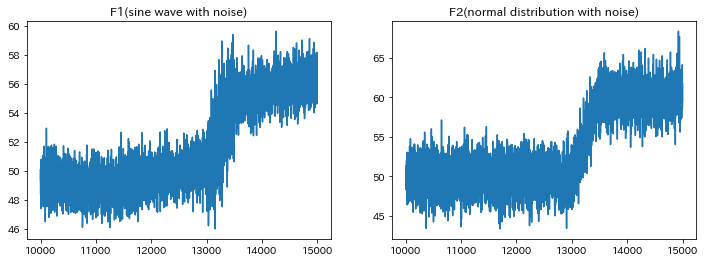

In [1005]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(create_df(10).iloc[10000: , 0])
plt.title("F1(sine wave with noise)")
plt.subplot(122)
plt.title("F2(normal distribution with noise)")
plt.plot(create_df(10).iloc[10000: , 1])
plt.show()

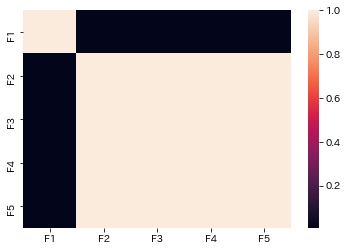

In [1006]:
sns.heatmap(create_df(4).iloc[:10000, :].corr())
plt.show()

# Build Models

In [800]:
def compute_mahalanobis(model, X_train, X_test):
    train_error = model.predict(X_train) - X_train
    cov = np.cov(train_error.reshape(-1, X_train.shape[-1]).T)
    mean = np.mean(train_error.reshape(-1, X_train.shape[-1]), axis=0)
    test_error = model.predict(X_test) - X_test
    temp_reshape = test_error.reshape(-1, test_error.shape[-1])
    return np.mean(np.array([distance.mahalanobis(mean, temp_reshape[i], cov) for i in range(len(temp_reshape))]).reshape(-1, X_train.shape[1]), axis=1)

In [793]:
def Usual_LSTM(X):
    hidden = 5
    timesteps=X.shape[1]
    num_features=X.shape[2]
    model = Sequential([
        LSTM(hidden, input_shape=(timesteps, num_features)),
        RepeatVector(timesteps),
        LSTM(hidden, return_sequences=True),
        TimeDistributed(Dense(num_features))                 
    ])
    model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model

In [823]:
class MyLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.units = units
    def build(self, input_shape):
        self.kernel = self.add_weight(
        "kernel", shape=[1, self.units],
        initializer='uniform', trainable=True,
        regularizer = tf.keras.regularizers.l1(0.001)
        )
    def call(self, input):
        output = input*self.kernel
        return tf.nn.relu(output) 

def Sparse_LSTM(X):
    hidden = 5
    timesteps=X.shape[1]
    num_features=X.shape[2]
    model = Sequential([
        Flatten(input_shape=(timesteps, num_features)),
        MyLayer(timesteps*num_features),
        Reshape(target_shape=(timesteps, num_features)),
        LSTM(hidden, input_shape=(timesteps, num_features)),
        RepeatVector(timesteps),
        LSTM(hidden, return_sequences=True),
        TimeDistributed(Dense(num_features))    
    ])
    model.compile( loss="mse", optimizer='adam')
    model.summary()
    return model

## Usual LSTM

### f1,f2

In [796]:
train = create_df(1).iloc[:10000]
test = create_df(1).iloc[10000:]
sc = StandardScaler()
train_std = pd.DataFrame(sc.fit_transform(train), columns=train.columns)
test_std = pd.DataFrame(sc.transform(test), columns=test.columns)

X_train, _ = preprocess().create_dataset(train_std, train_std, time_steps=15)
X_test , _ = preprocess().create_dataset(test_std, test_std, time_steps=15)

In [797]:
model = Usual_LSTM(X_train)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 5)                 160       
_________________________________________________________________
repeat_vector_26 (RepeatVect (None, 15, 5)             0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 15, 5)             220       
_________________________________________________________________
time_distributed_26 (TimeDis (None, 15, 2)             12        
Total params: 392
Trainable params: 392
Non-trainable params: 0
_________________________________________________________________


In [798]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
            X_train, X_train,
            epochs=30,
            batch_size=128,
            validation_split=0.1,
            callbacks = [es],
            shuffle=False
        )

Train on 8986 samples, validate on 999 samples
Epoch 1/30
8986/8986 [==============================] - 8s 930us/sample - loss: 1.0391 - val_loss: 0.8372
Epoch 2/30
8986/8986 [==============================] - 1s 111us/sample - loss: 0.9885 - val_loss: 0.8079
Epoch 3/30
8986/8986 [==============================] - 1s 111us/sample - loss: 0.9075 - val_loss: 0.7824
Epoch 4/30
8986/8986 [==============================] - 1s 108us/sample - loss: 0.8643 - val_loss: 0.7794
Epoch 5/30
8986/8986 [==============================] - 1s 107us/sample - loss: 0.8489 - val_loss: 0.7721
Epoch 6/30
8986/8986 [==============================] - 1s 108us/sample - loss: 0.8391 - val_loss: 0.7666
Epoch 7/30
8986/8986 [==============================] - 1s 108us/sample - loss: 0.8316 - val_loss: 0.7628
Epoch 8/30
8986/8986 [==============================] - 1s 106us/sample - loss: 0.8258 - val_loss: 0.7600
Epoch 9/30
8986/8986 [==============================] - 1s 113us/sample - loss: 0.8214 - val_loss: 0.7580

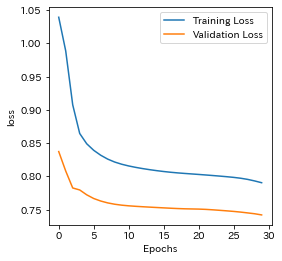

In [799]:
preprocess().plotting_history(history)

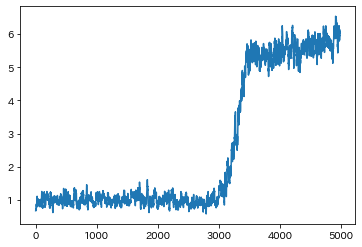

In [801]:
plt.plot(compute_mahalanobis(model, X_train, X_test))
plt.show()

### f1,f2,f3,f4,f5

In [802]:
train = create_df(4).iloc[:10000]
test = create_df(4).iloc[10000:]
sc = StandardScaler()
train_std = pd.DataFrame(sc.fit_transform(train), columns=train.columns)
test_std = pd.DataFrame(sc.transform(test), columns=test.columns)

X_train, _ = preprocess().create_dataset(train_std, train_std, time_steps=15)
X_test , _ = preprocess().create_dataset(test_std, test_std, time_steps=15)

In [803]:
model = Usual_LSTM(X_train)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 5)                 220       
_________________________________________________________________
repeat_vector_27 (RepeatVect (None, 15, 5)             0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 15, 5)             220       
_________________________________________________________________
time_distributed_27 (TimeDis (None, 15, 5)             30        
Total params: 470
Trainable params: 470
Non-trainable params: 0
_________________________________________________________________


In [804]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
            X_train, X_train,
            epochs=30,
            batch_size=128,
            validation_split=0.1,
            callbacks = [es],
            shuffle=False
        )

Train on 8986 samples, validate on 999 samples
Epoch 1/30
8986/8986 [==============================] - 9s 992us/sample - loss: 1.0102 - val_loss: 0.8694
Epoch 2/30
8986/8986 [==============================] - 1s 117us/sample - loss: 0.9759 - val_loss: 0.8428
Epoch 3/30
8986/8986 [==============================] - 1s 117us/sample - loss: 0.9536 - val_loss: 0.8398
Epoch 4/30
8986/8986 [==============================] - 1s 118us/sample - loss: 0.9414 - val_loss: 0.8339
Epoch 5/30
8986/8986 [==============================] - 1s 126us/sample - loss: 0.9267 - val_loss: 0.8247
Epoch 6/30
8986/8986 [==============================] - 1s 117us/sample - loss: 0.9137 - val_loss: 0.8189
Epoch 7/30
8986/8986 [==============================] - 1s 117us/sample - loss: 0.9053 - val_loss: 0.8153
Epoch 8/30
8986/8986 [==============================] - 1s 121us/sample - loss: 0.9005 - val_loss: 0.8129
Epoch 9/30
8986/8986 [==============================] - 1s 119us/sample - loss: 0.8976 - val_loss: 0.8118

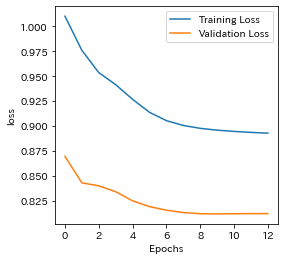

In [805]:
preprocess().plotting_history(history)

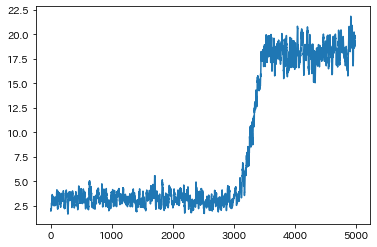

In [806]:
plt.plot(compute_mahalanobis(model, X_train, X_test))
plt.show()

### f1,f2,f3,f4,f5,f6,f7,f8,f9,f10

In [946]:
train = create_df(9).iloc[:10000]
test = create_df(9).iloc[10000:]
sc = StandardScaler()
train_std = pd.DataFrame(sc.fit_transform(train), columns=train.columns)
test_std = pd.DataFrame(sc.transform(test), columns=test.columns)

X_train, _ = preprocess().create_dataset(train_std, train_std, time_steps=15)
X_test , _ = preprocess().create_dataset(test_std, test_std, time_steps=15)

In [947]:
model = Usual_LSTM(X_train)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 5)                 320       
_________________________________________________________________
repeat_vector_35 (RepeatVect (None, 15, 5)             0         
_________________________________________________________________
lstm_71 (LSTM)               (None, 15, 5)             220       
_________________________________________________________________
time_distributed_35 (TimeDis (None, 15, 10)            60        
Total params: 600
Trainable params: 600
Non-trainable params: 0
_________________________________________________________________


In [948]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
            X_train, X_train,
            epochs=30,
            batch_size=128,
            validation_split=0.1,
            callbacks = [es],
            shuffle=False
        )

Train on 8986 samples, validate on 999 samples
Epoch 1/30
8986/8986 [==============================] - 14s 2ms/sample - loss: 1.0005 - val_loss: 0.8794
Epoch 2/30
8986/8986 [==============================] - 1s 127us/sample - loss: 0.9785 - val_loss: 0.8562
Epoch 3/30
8986/8986 [==============================] - 1s 127us/sample - loss: 0.9505 - val_loss: 0.8375
Epoch 4/30
8986/8986 [==============================] - 1s 128us/sample - loss: 0.9350 - val_loss: 0.8302
Epoch 5/30
8986/8986 [==============================] - 1s 128us/sample - loss: 0.9284 - val_loss: 0.8282
Epoch 6/30
8986/8986 [==============================] - 1s 129us/sample - loss: 0.9254 - val_loss: 0.8270
Epoch 7/30
8986/8986 [==============================] - 1s 128us/sample - loss: 0.9238 - val_loss: 0.8261
Epoch 8/30
8986/8986 [==============================] - 1s 128us/sample - loss: 0.9227 - val_loss: 0.8253
Epoch 9/30
8986/8986 [==============================] - 1s 129us/sample - loss: 0.9218 - val_loss: 0.8245


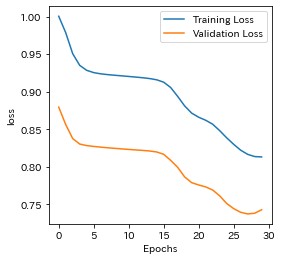

In [949]:
preprocess().plotting_history(history)

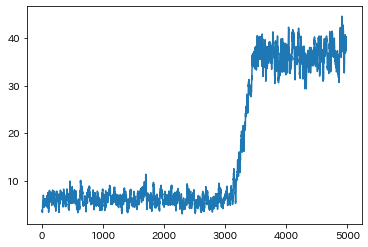

In [950]:
plt.plot(compute_mahalanobis(model, X_train, X_test))
plt.show()

## Sparse LSTM

In [1011]:
train = create_df(4).iloc[:10000]
test = create_df(4).iloc[10000:]
sc = StandardScaler()
train_std = pd.DataFrame(sc.fit_transform(train), columns=train.columns)
test_std = pd.DataFrame(sc.transform(test), columns=test.columns)

X_train, _ = preprocess().create_dataset(train_std, train_std, time_steps=15)
X_test , _ = preprocess().create_dataset(test_std, test_std, time_steps=15)

In [1012]:
model = Sparse_LSTM(X_train)

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 75)                0         
_________________________________________________________________
my_layer_9 (MyLayer)         (None, 75)                75        
_________________________________________________________________
reshape_9 (Reshape)          (None, 15, 5)             0         
_________________________________________________________________
lstm_78 (LSTM)               (None, 5)                 220       
_________________________________________________________________
repeat_vector_39 (RepeatVect (None, 15, 5)             0         
_________________________________________________________________
lstm_79 (LSTM)               (None, 15, 5)             220       
_________________________________________________________________
time_distributed_39 (TimeDis (None, 15, 5)           

In [1013]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
history = model.fit(
            X_train, X_train,
            epochs=30,
            batch_size=128,
            validation_split=0.1,
            callbacks = [es],
            shuffle=False
        )

Train on 8986 samples, validate on 999 samples
Epoch 1/30
8986/8986 [==============================] - 29s 3ms/sample - loss: 1.0177 - val_loss: 0.8805
Epoch 2/30
8986/8986 [==============================] - 1s 133us/sample - loss: 1.0159 - val_loss: 0.8805
Epoch 3/30
8986/8986 [==============================] - 1s 141us/sample - loss: 1.0156 - val_loss: 0.8806
Epoch 4/30
8986/8986 [==============================] - 1s 138us/sample - loss: 1.0154 - val_loss: 0.8806
Epoch 5/30
8986/8986 [==============================] - 1s 132us/sample - loss: 1.0153 - val_loss: 0.8807
Epoch 6/30
8986/8986 [==============================] - 1s 129us/sample - loss: 1.0152 - val_loss: 0.8807
Epoch 7/30
8986/8986 [==============================] - 1s 132us/sample - loss: 1.0151 - val_loss: 0.8807


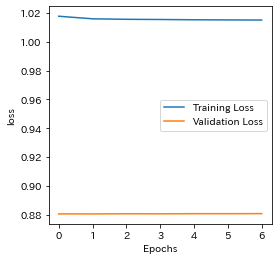

In [1014]:
preprocess().plotting_history(history)

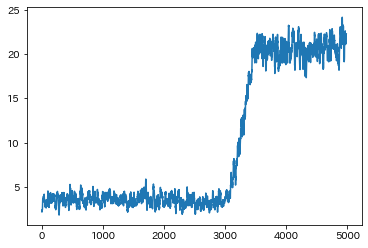

In [1015]:
plt.plot(compute_mahalanobis(model, X_train, X_test))
plt.show()

In [1016]:
model_weight = model.layers[1].get_weights()[0]
model_weight_reshaped = model_weight.reshape(15, 5)
model_weight_reshaped_mul_X_train =  model_weight_reshaped*X_train
model_weight_reshaped_mul_X_train_relu = np.max([np.zeros(model_weight_reshaped_mul_X_train.shape).ravel() , model_weight_reshaped_mul_X_train.ravel() ], axis=0).reshape(-1, 15, 5)

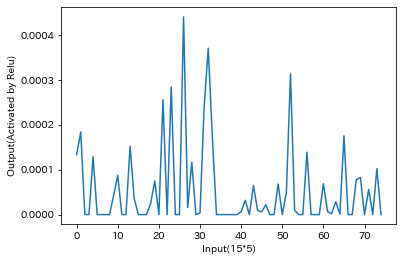

In [1036]:
plt.plot( model_weight_reshaped_mul_X_train_relu[0, :, :].ravel() )
plt.xlabel("Input(15*5)")
plt.ylabel("Output(Activated by Relu)")
plt.show()

In [ ]:
train = create_df(1).iloc[:10000]
test = create_df(1).iloc[10000:]
sc = StandardScaler()
train_std = pd.DataFrame(sc.fit_transform(train), columns=train.columns)
test_std = pd.DataFrame(sc.transform(test), columns=test.columns)

X_train, _ = preprocess().create_dataset(train_std, train_std, time_steps=15)
X_test , _ = preprocess().create_dataset(test_std, test_std, time_steps=15)

In [ ]:
model = Sparse_LSTM(X_train)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
history = model.fit(
            X_train, X_train,
            epochs=30,
            batch_size=128,
            validation_split=0.1,
            callbacks = [es],
            shuffle=False
        )

In [ ]:
preprocess().plotting_history(history)

In [ ]:
plt.plot(compute_mahalanobis(model, X_train, X_test))
plt.show()